In [1]:
fold_validation_patient = 'ACel'
fold_model_path = '../logs/2021-02-17-11:51:17_fold0/best_model_62_dsc=0.9712.pt'

In [2]:
import sys
sys.path.append('../models')
sys.path.append('../dataset_pericardium')
from unet_plain import UNet
from patients_dataset import PatientsDataset
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
dataset = PatientsDataset(
    patient_names=[fold_validation_patient],
    inputs_dir=os.path.join('../dataset_pericardium_manual_polar/', 'input'),
    labels_dir=os.path.join('../dataset_pericardium_manual_polar/', 'label'),
    image_size=128,
    random_sampling=False,
)

reading images...
preprocessing volumes...
resizing volumes...
normalizing volumes...
done creating dataset


In [4]:
def show_images_row(imgs, titles=None, rows=1, figsize=(6.4, 4.8), **kwargs):
    '''
       Display grid of cv2 images image
       :param img: list [cv::mat]
       :param title: titles
       :return: None
    '''
    assert ((titles is None) or (len(imgs) == len(titles)))
    num_images = len(imgs)

    if titles is None:
        titles = ['Image (%d)' % i for i in range(1, num_images + 1)]

    fig = plt.figure(figsize=figsize)
    for n, (image, title) in enumerate(zip(imgs, titles)):
        ax = fig.add_subplot(rows, np.ceil(num_images / float(rows)), n + 1)
        plt.imshow(image, **kwargs)
        ax.set_title(title)
        plt.axis('off')
    plt.show()

In [5]:
all_xs = []
all_ys = []
for (x, y) in dataset:
    all_xs.append(x.squeeze(0))
    all_ys.append(y.squeeze(0))

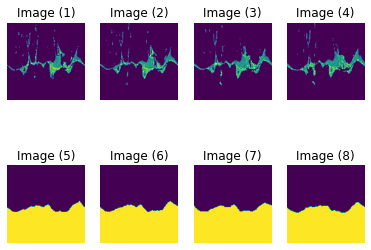

In [6]:
show_images_row(all_xs[20:24] + all_ys[20:24], rows=2)

In [7]:
model = UNet(in_channels=1, out_channels=1, device='cuda')
model.to('cuda')
model.load_state_dict(torch.load(fold_model_path))
model.eval()

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [8]:
all_predicted_ys = []
for (x, y) in dataset:
    x = x.to('cuda')
    predicted_y = model(x.unsqueeze(0))
    all_predicted_ys.append(predicted_y.squeeze(0).squeeze(0).detach().cpu())

torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
torch.cuda.FloatTensor
-0.5 -0.5 0.5
t

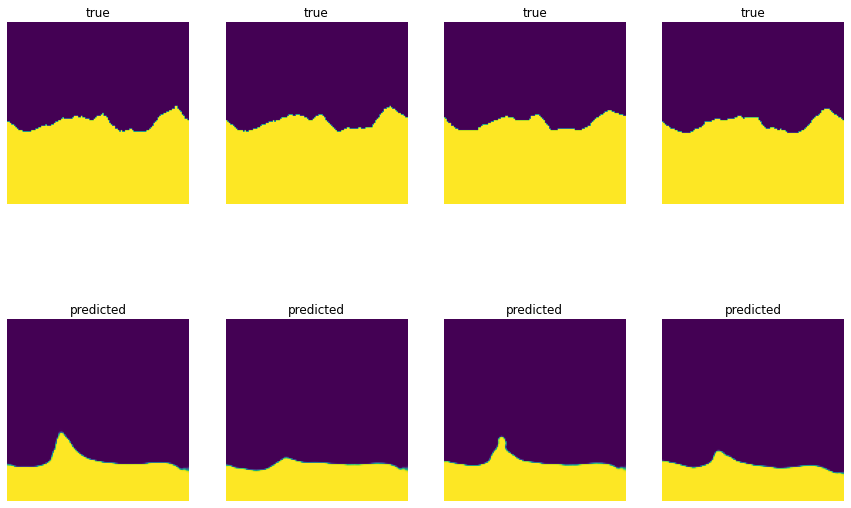

In [9]:
show_images_row(
    all_ys[20:24] + all_predicted_ys[20:24], 
    titles=['true' for i in range(4)] + ['predicted' for i in range(4)], 
    rows=2,
    figsize=(15, 10))

In [10]:
print(all_predicted_ys[0])

tensor([[7.8726e-04, 6.5497e-04, 5.8536e-04,  ..., 5.5676e-04, 6.7845e-04,
         9.1265e-04],
        [5.1263e-04, 5.4112e-04, 5.9049e-04,  ..., 5.8173e-04, 5.7812e-04,
         5.0050e-04],
        [5.3666e-04, 5.5791e-04, 5.6476e-04,  ..., 6.1768e-04, 5.1743e-04,
         4.7595e-04],
        ...,
        [9.9944e-01, 9.9943e-01, 9.9939e-01,  ..., 9.8393e-01, 9.1714e-01,
         8.1202e-01],
        [9.9873e-01, 9.9891e-01, 9.9924e-01,  ..., 8.3428e-01, 6.7719e-01,
         7.4670e-01],
        [9.9896e-01, 9.9930e-01, 9.9941e-01,  ..., 9.9312e-01, 9.8960e-01,
         9.1640e-01]])


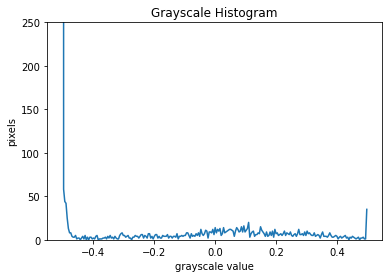

In [11]:
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
histogram, bin_edges = np.histogram(all_xs[20], bins=256, range=(all_xs[20].min().item(), all_xs[20].max().item()))
plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.ylim((0, 250))
plt.show()

-0.5


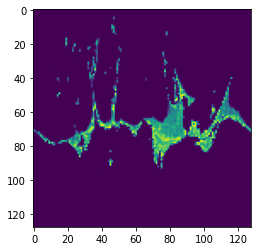

In [12]:
volume = dataset.volumes[0][0].copy()
p = np.percentile(volume, 87)
plt.imshow(volume[20])
print(volume.min())

-0.5


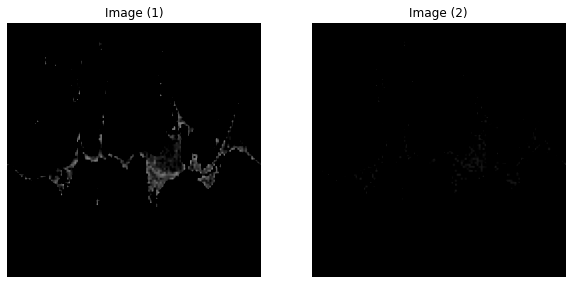

In [13]:
from skimage.exposure import rescale_intensity

def normalize_volume(volume):
    v = volume.copy()
    unnormalized = v.copy()
    v[v > 0.1] = 0
    #fat = rescale_intensity(fat, out_range=(0.1, 1))
    return v

normalized = normalize_volume(volume.copy())
print(np.median(normalized))

show_images_row([volume[20], normalized[20]], figsize=(10, 5), vmin=0, vmax=1, cmap="gray")

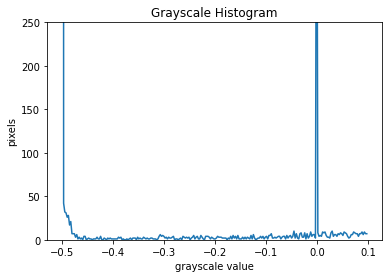

In [14]:
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
histogram, bin_edges = np.histogram(normalized[20], bins=256)
plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.ylim((0, 250))
plt.show()